In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B

In [3]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [4]:
import pandas as pd

foam_df = pd.read_excel("/mnt/data_dzne_archiv2/Studien/Deep_Learning_Visualization/temporary_stuff/Jaya_Chandra_Terli/SS-2025/SLB-Project/Navier_Stokes_cylinder2D/data/Re40_Med_10k/foam_re40.xlsx")

# foam_df.head()
foam_df['cx'] = foam_df['cx'].apply(lambda x: x+ 0.5)
foam_df['cy'] = foam_df['cy'].apply(lambda x: x+ 0.5)
# foam_df['U'] = foam_df['U'].apply(lambda x: x[0].split(' '))
# foam_df.head()

# Split U column into u, v (ignore the third value)
foam_df[['u', 'v', '_']] = foam_df['U'].str.extract(r'\(?\s*([-\d.eE]+)\s+([-\d.eE]+)\s+([-\d.eE]+)\s*\)?')
foam_df['u'] = foam_df['u'].astype(float)
foam_df['v'] = foam_df['v'].astype(float)
foam_df['p'] = foam_df['p'].astype(float)

# foam_df.head()
x_of = foam_df['cx'].values
y_of = foam_df['cy'].values
u_of = foam_df['u'].values
v_of = foam_df['v'].values
p_of = foam_df['p'].values

(x_of.dtype, x_of.shape), (y_of.dtype, y_of.shape), (u_of.dtype, u_of.shape), (v_of.dtype, v_of.shape), (p_of.dtype, p_of.shape)

((dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)),
 (dtype('float64'), (23814,)))

In [5]:
def plot_xy_sel_with_domain(xy_sel, x_ini=0, x_f=2, y_ini=0, y_f=1, circle_center=(0.5, 0.5), circle_radius=0.1, title="xy_sel with Domain"):
    """
    Plot xy_sel points with rectangle domain and inner circle.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, Circle

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(xy_sel[:, 0], xy_sel[:, 1], s=5, c='blue', alpha=0.5, label="Selected Points")
    # Draw rectangle (domain)
    rect = Rectangle((x_ini, y_ini), x_f - x_ini, y_f - y_ini, linewidth=2, edgecolor='black', facecolor='none', label="Domain")
    ax.add_patch(rect)
    # Draw circle (obstacle)
    # circle = Circle(circle_center, circle_radius, color='gray', fill=False, linestyle='--', linewidth=2, label="Cylinder")
    # ax.add_patch(circle)
    ax.set_xlim(x_ini-0.1, x_f+0.1)
    ax.set_ylim(y_ini-0.1, y_f+0.1)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.show()


# plot_xy_sel_with_domain(xy_sel, title="Selected OpenFoam Points with Domain and Cylinder")

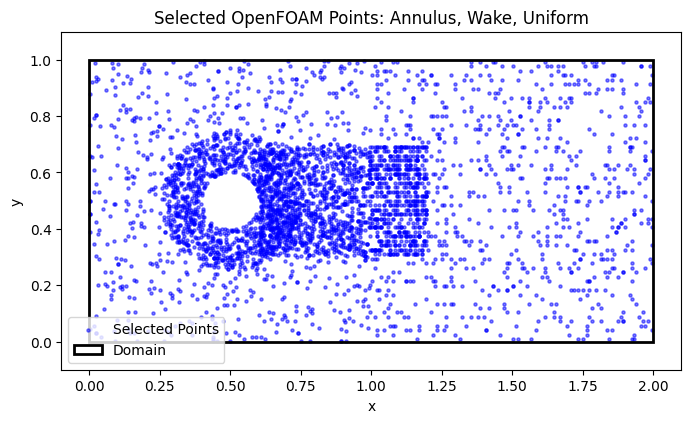

In [6]:
import numpy as np
from scipy.spatial import cKDTree

# Domain/cylinder parameters
Cx, Cy = 0.5, 0.5
a, b = 0.1, 0.1

# 1. Annulus around cylinder (outer radius 0.25)
num_annulus_samples = 1000
theta = np.random.uniform(0, 2*np.pi, num_annulus_samples)
r = np.sqrt(np.random.uniform(1, 6, num_annulus_samples)) * a  # sqrt for uniform area, scale for radius
x_annulus = Cx + r * np.cos(theta)
y_annulus = Cy + r * np.sin(theta)
xyt_annulus = np.stack([x_annulus, y_annulus], axis=1)

# 2. Wake region rectangle
num_strip_samples = 1500
x_strip = np.random.uniform(0.6, 1.2, num_strip_samples)
y_strip = np.random.uniform(0.3, 0.7, num_strip_samples)
xyt_strip = np.stack([x_strip, y_strip], axis=1)

# 3. Uniform points elsewhere (excluding cylinder, annulus, and wake)

num_uniform = 4000 - num_annulus_samples - num_strip_samples
# xy_uniform = uniform_points_in_domain_exclusive(num_uniform)

def uniform_points_in_domain(n_points, x_ini=0, x_f=2, y_ini=0, y_f=1, circle_center=(0.5, 0.5), circle_radius=0.1):
    points = []
    while len(points) < n_points:
        x = np.random.uniform(x_ini, x_f)
        y = np.random.uniform(y_ini, y_f)
        if ((x - circle_center[0])**2 + (y - circle_center[1])**2) >= circle_radius**2:
            points.append([x, y])
    return np.array(points)

xy_uniform = uniform_points_in_domain(num_uniform)

# Combine all regions
xyt_roi = np.concatenate([xyt_annulus, xyt_strip, xy_uniform], axis=0)

mask_outside_cylinder = ((xyt_roi[:, 0] - Cx)**2 / a**2 + (xyt_roi[:, 1] - Cy)**2 / b**2) >= 1
xyt_roi = xyt_roi[mask_outside_cylinder]

# KDTree selection from OpenFOAM points
coords_of = np.stack((x_of, y_of), axis=-1)
tree = cKDTree(coords_of)
_, indices = tree.query(xyt_roi, k=1)
x_sel = x_of[indices]
y_sel = y_of[indices]
u_sel = u_of[indices]
v_sel = v_of[indices]
p_sel = p_of[indices]
xy_sel = np.stack((x_sel, y_sel), axis=-1)

# Plot to check
plot_xy_sel_with_domain(xy_sel, title="Selected OpenFOAM Points: Annulus, Wake, Uniform")

In [7]:
uv_sel = np.stack((u_sel, v_sel, p_sel), axis=-1)
uv_sel.shape, xy_sel.shape

((4000, 3), (4000, 2))

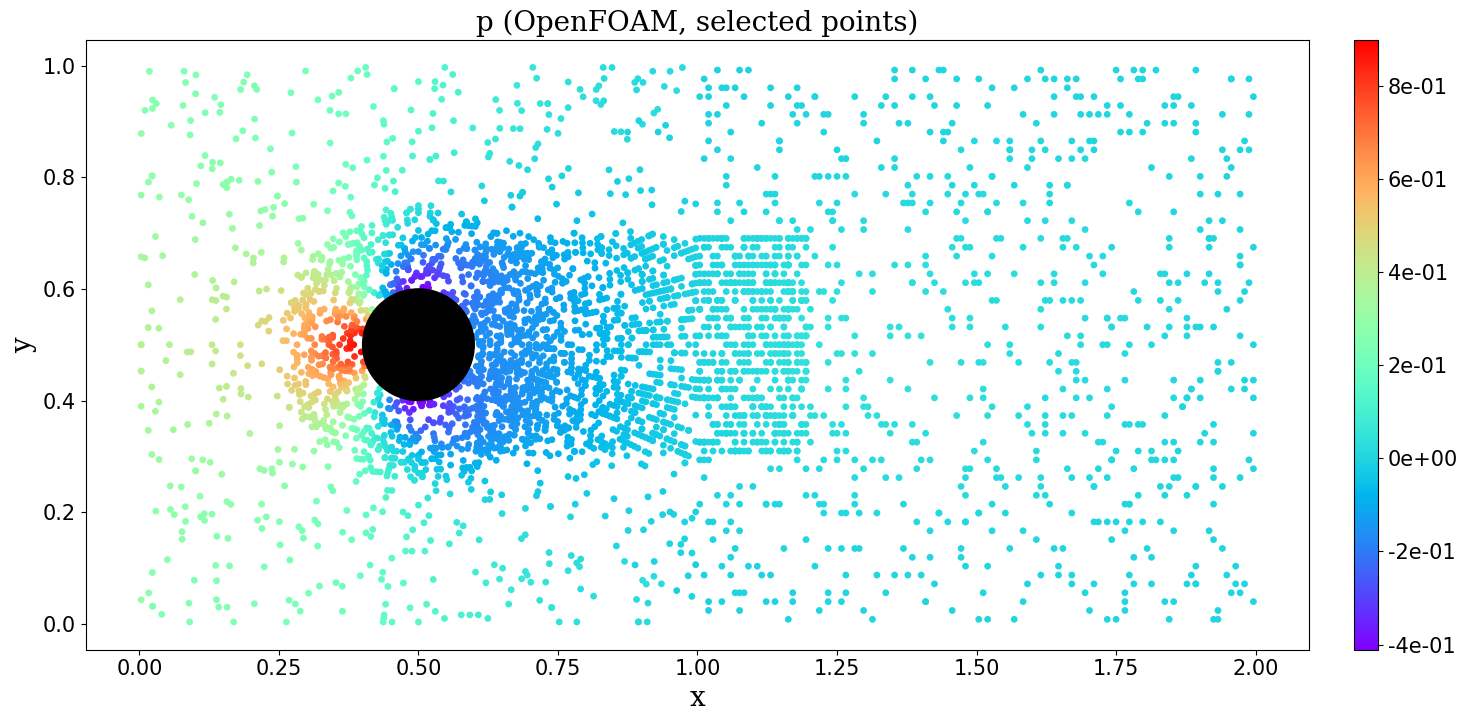

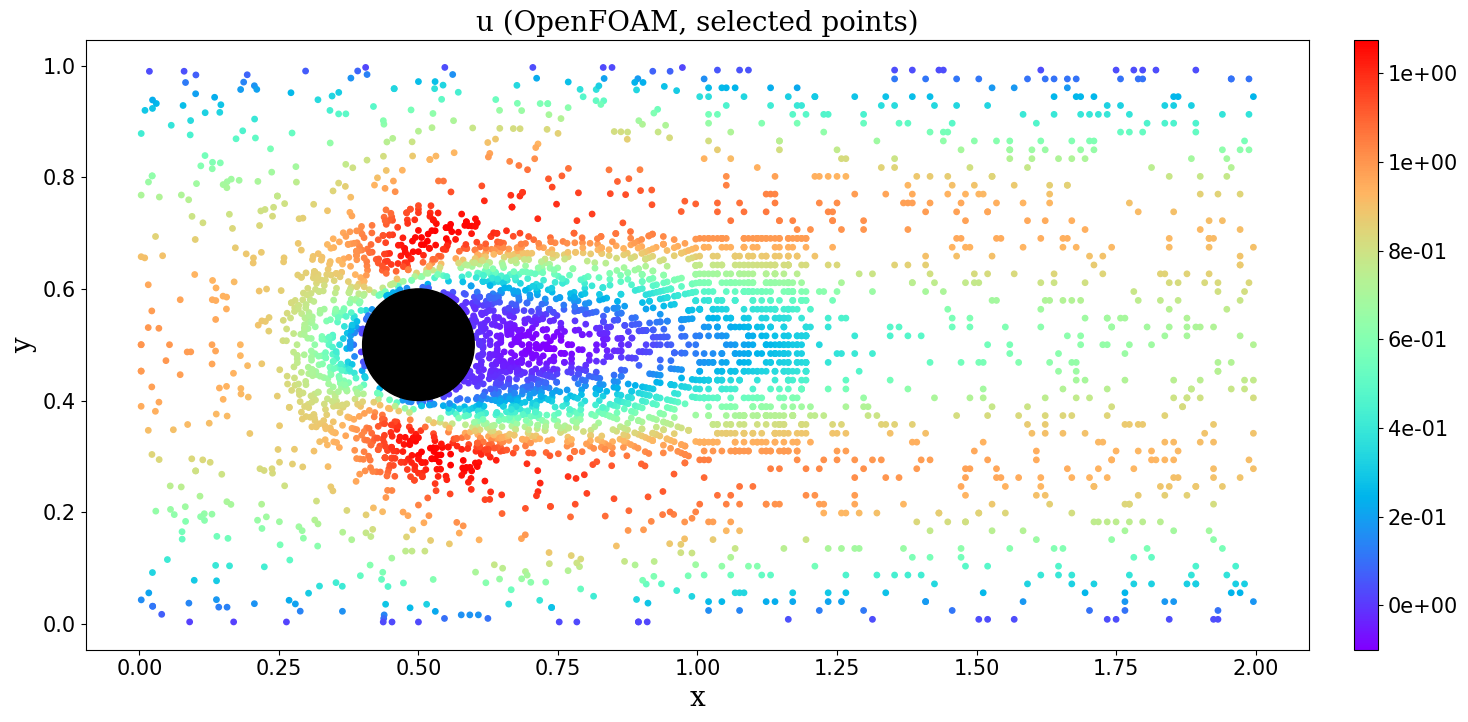

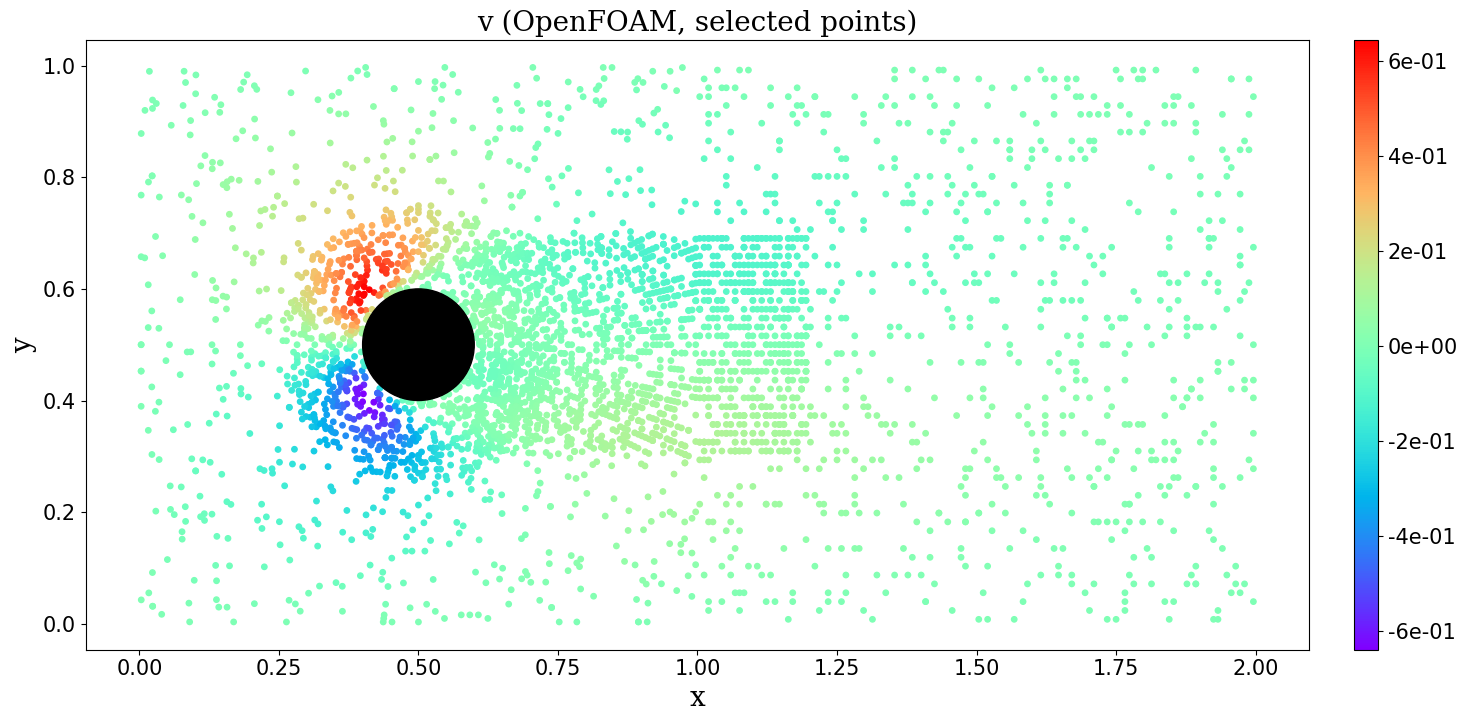

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}


# Plot p (velocity x) as scatter
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
sc = ax.scatter(x_sel, y_sel, c=p_sel, cmap='rainbow', s=15, marker='o')
cbar = plt.colorbar(sc, ax=ax, pad=0.03, aspect=25, format='%.0e')
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black", zorder=10))
ax.set_aspect('equal')
plt.title("p (OpenFOAM, selected points)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

# Plot u (velocity x) as scatter
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
sc = ax.scatter(x_sel, y_sel, c=u_sel, cmap='rainbow', s=15, marker='o')
cbar = plt.colorbar(sc, ax=ax, pad=0.03, aspect=25, format='%.0e')
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black", zorder=10))
ax.set_aspect('equal')
plt.title("u (OpenFOAM, selected points)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

# Plot v (velocity y) as scatter
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
sc = ax.scatter(x_sel, y_sel, c=v_sel, cmap='rainbow', s=15, marker='o')
cbar = plt.colorbar(sc, ax=ax, pad=0.03, aspect=25, format='%.0e')
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black", zorder=10))
ax.set_aspect('equal')
plt.title("v (OpenFOAM, selected points)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [9]:
# if __name__ == '__main__':
"""
Test the physics informed neural network (PINN) model
for the cavity flow governed by the steady Navier-Stokes equation.
"""

# number of training samples
num_train_samples = 4000
# number of test samples
num_test_samples = 200

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
mu = 0.025
# Re = (L*u0*rho)/mu ==> rho/mu = 40

# build a core network model
network = Network().build()
network.summary()
# build a PINN model
pinn = PINN(network, rho=rho, mu=mu).build()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 48)                144       
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dense_3 (Dense)             (None, 48)                2352      
                                                                 
 dense_4 (Dense)             (None, 3)                 147       
                                                                 
Total params: 7347 (28.70 KB)
Trainable params: 7347 (28.70 K

In [11]:

# Domain and circle data
x_f =2
x_ini=0
y_f=1
y_ini=0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# create training input
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

corner_buffer = 0.05
max_attempts = 100

for i in range(num_train_samples):
    attempts = 0
    while True:
        inside_cylinder = (xyt_eqn[i, 0] - Cx)**2 / a**2 + (xyt_eqn[i, 1] - Cy)**2 / b**2 < 1
        near_corner = (
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer)
        )

        if not (inside_cylinder or near_corner):
            break

        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand() + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand() + y_ini

        attempts += 1
        if attempts > max_attempts:
            print(f"Warning: Max attempts reached for sample {i}")
            break  # Accept the current (possibly imperfect) point or skip


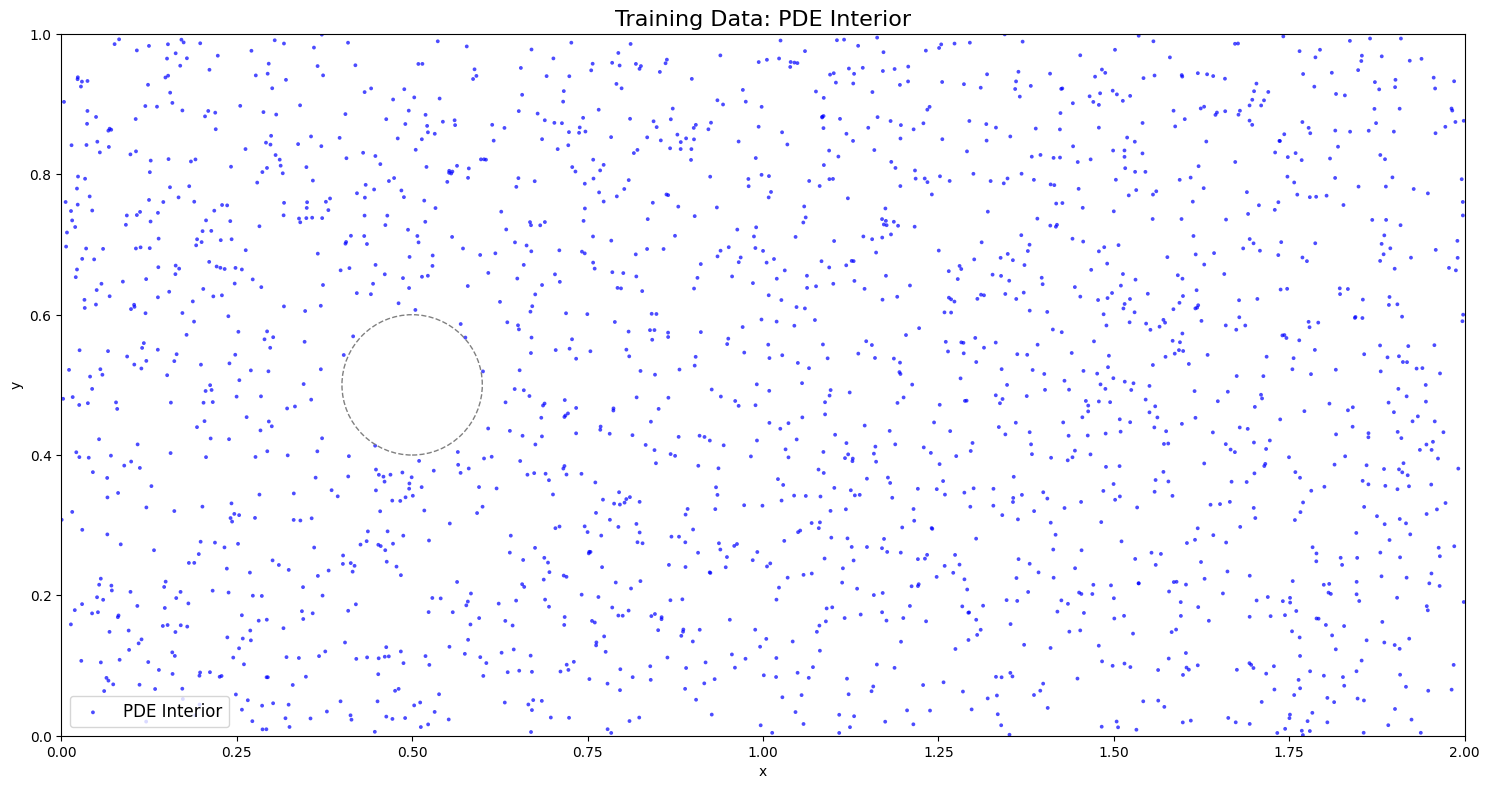

In [13]:
# --- Plot training data distribution (separate plots, distinct markers) ---
import matplotlib.pyplot as plt

def subsample(arr, max_points=2000):
    if arr.shape[0] > max_points:
        idx = np.random.choice(arr.shape[0], max_points, replace=False)
        return arr[idx]
    return arr

data_labels = [
    ("PDE Interior", xyt_eqn, 'blue', '.', 30)
]

for label, data, color, marker, size in data_labels:
    arr = subsample(data)
    plt.figure(figsize=(15, 10))
    plt.scatter(arr[:, 0], arr[:, 1], s=size, c=color, alpha=0.7, marker=marker, label=label, edgecolors='none')
    plt.title(f"Training Data: {label}", fontsize=16)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.gca().set_aspect('equal')
    plt.legend(loc='best', fontsize=12)
    # Draw cylinder for reference
    circle = plt.Circle((0.5, 0.5), 0.1, color='gray', fill=False, linestyle='--')
    plt.gca().add_patch(circle)
    plt.tight_layout()
    plt.show()

In [12]:

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[...,0] = x_ini

x_train = [xy_sel, xyt_eqn, xyt_w1, xyt_w2, xyt_out, xyt_in, xyt_circle]

# create training output
zeros = np.zeros((num_train_samples, 3))
#uv_bnd[..., 0] = -u0 * np.floor(xy_bnd[..., 0]) +1
#ones = np.ones((num_train_samples, 3))
#onze = np.random.rand(num_train_samples, 3)
#onze[...,0] = u0
#onze[...,1] = 0
#onze[...,2] = u0
a = u_0(tf.constant(xyt_in)).numpy()
b = np.zeros((num_train_samples, 1))
onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))

y_train = [uv_sel, zeros, onze, zeros, zeros, zeros, zeros]


In [13]:
print("Training data shapes:")
print("Labels of x: (x_cord, y_cord), y: (u, v, p)")
for x, y in zip(x_train, y_train):
    print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Training data shapes:
Labels of x: (x_cord, y_cord), y: (u, v, p)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)


In [14]:
loss_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0]

In [15]:
from optimizer import L_BFGS_B
# train the model using L-BFGS-B algorithm
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train, factr=1e5, m=50, maxls=50, maxiter=30000, loss_weights=loss_weights)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:   0%|          | 0/30000 [00:00<?, ?iter/s]

L-BFGS-B:  12%|█▏        | 3562/30000 [09:14<1:08:38,  6.42iter/s, loss=0.106] 


In [21]:
# pinn.save("re40_of_wl10cyl.h5")
network.save("re40_of_wl10cyl.h5")

/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from tensorflow.keras.models import load_model
from layer import GradientLayer

loaded_pinn = load_model("pinn_dummysave.h5", custom_objects={'GradientLayer': GradientLayer})

In [23]:
loaded_pinn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 gradient_layer (GradientLa  (((None, 1),                 7347      ['input_2[0][0]',             
 yer)                         (None, 1),                             'input_3[0][0]',             
                              (None, 1)),                            'input_5[0][0]',             
                              ((None, 1),                            'input_6[0][0]',       

In [ ]:
# 1e2
# Optimizer: L-BFGS-B (maxiter=30000)
# L-BFGS-B:  22%|██▏       | 6611/30000 [14:11<50:13,  7.76iter/s, loss=0.127]

# 1e3
# Optimizer: L-BFGS-B (maxiter=30000)
# L-BFGS-B:  26%|██▌       | 7772/30000 [15:55<45:31,  8.14iter/s, loss=0.13]

# 1e5
# Optimizer: L-BFGS-B (maxiter=30000)
# L-BFGS-B:  14%|█▎        | 4103/30000 [10:12<1:04:23,  6.70iter/s, loss=0.128]

# 1e7


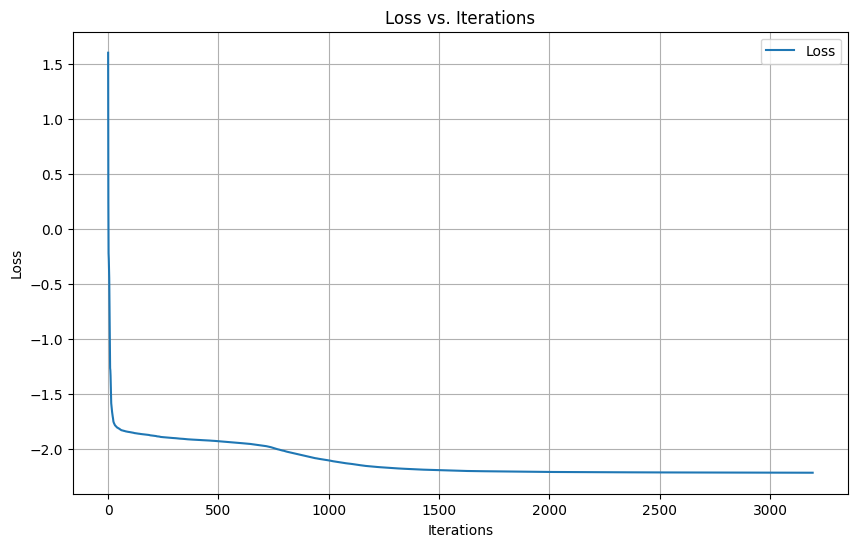

In [21]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(lbfgs.loss_history)), np.log(lbfgs.loss_history), label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid()
plt.show()

In [19]:
def plot_profiles(x, y, u, v, cross_sections, save_csv=False, prefix="u10", location="data/pinn_profiles/"):
    """
    Plot velocity profiles (u, v) along specified cross-sections and optionally save u profiles to CSV.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
        save_csv: If True, save u profiles to CSV files.
        prefix: Prefix for CSV filenames.
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: y as 'x', u as 'u'
                df = pd.DataFrame({'x': y[:, idx], 'u': u[:, idx]})
                filename = f"{prefix}_{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: x as 'x', u as 'u'
                df = pd.DataFrame({'x': x[idx, :], 'u': u[idx, :]})
                filename = f"{prefix}_y{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)

In [24]:

# create meshgrid coordinates (x, y) for test plots    
# from utils import contour_neu as contour
x = np.linspace(x_ini, x_f, num_test_samples+200)
y = np.linspace(y_ini, y_f, num_test_samples+200)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
# predict (psi, p)
# u_v_p = network.predict(xy, batch_size=len(xy))
u_v_p = loaded_pinn.predict(xy, batch_size=len(xy))
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)

ValueError: in user code:

    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 7 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(160000, 2) dtype=float32>]


In [24]:
u.shape, v.shape, p.shape, x.shape, y.shape

((400, 400), (400, 400), (400, 400), (400, 400), (400, 400))

In [25]:
def contour(x, y, z, title, levels=200):
    """
    Contour plot.
    Args:
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
        circle_center: (x, y) center of the circle.
        circle_radius: radius of the circle.
    """
    circle_center = (0.5, 0.5)
    circle_radius = 0.1
    vmin = np.min(z)
    vmax = np.max(z)
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    ax = plt.gca()
    ax.set_aspect('equal')
    circle = plt.Circle(circle_center, circle_radius, fc='black', zorder=10)
    ax.add_patch(circle)
    plt.title(title, fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

In [ ]:

# plot test results
fig = plt.figure(figsize=(16, 8))
contour(x, y, p, 'p')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, u, 'u')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, v, 'v')
plt.tight_layout()
plt.show()


###########################
from matplotlib.patches import Circle
font1 = {'family':'serif','size':20}

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("p", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, )
plt.title("u", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("v", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

############################ 


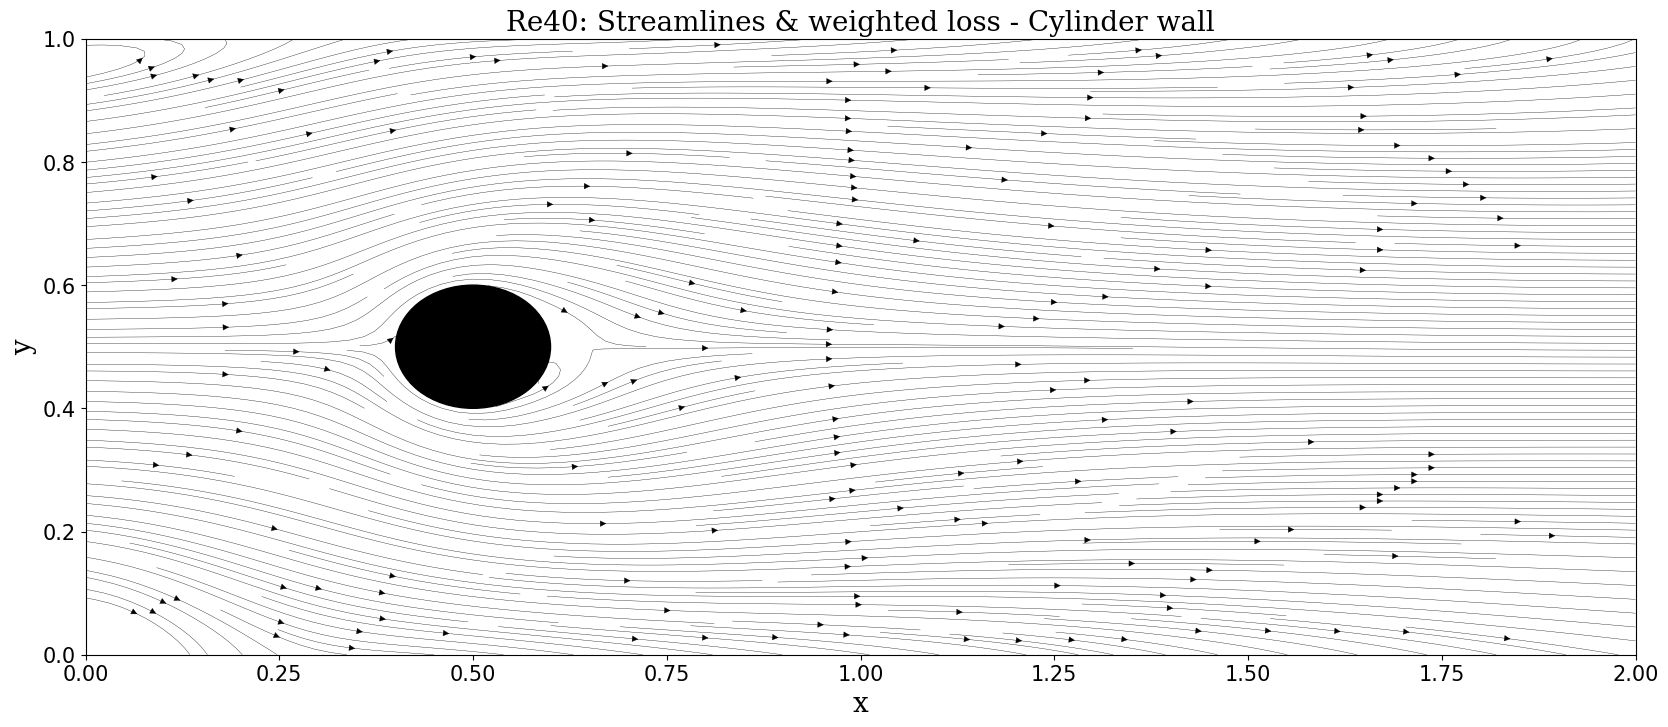

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
# Contourf for pressure (or any scalar field)
# cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
# cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=3, linewidth=0.25)
# Add cylinder
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("Re40: Streamlines & weighted loss - Cylinder wall", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.savefig('u_streamlines_Re40_of_roie5_wl10cyl.png', dpi=300)
plt.show()

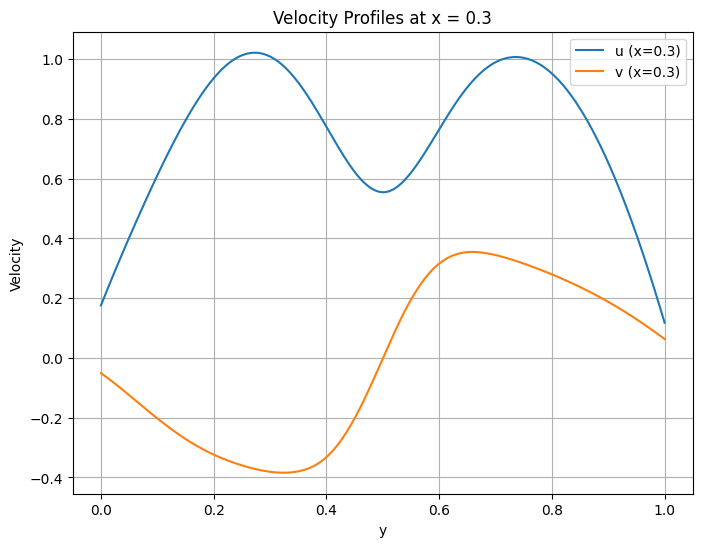

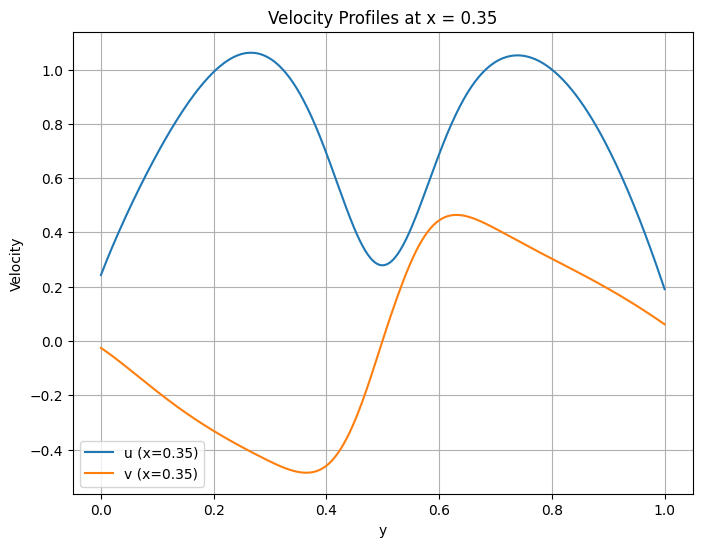

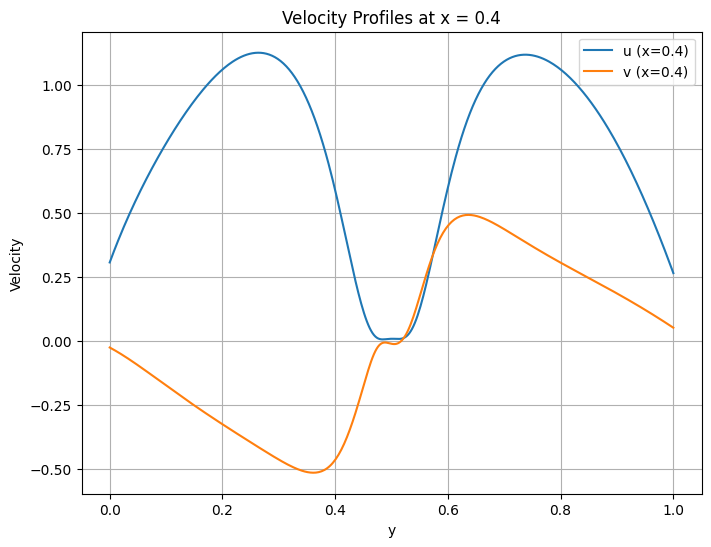

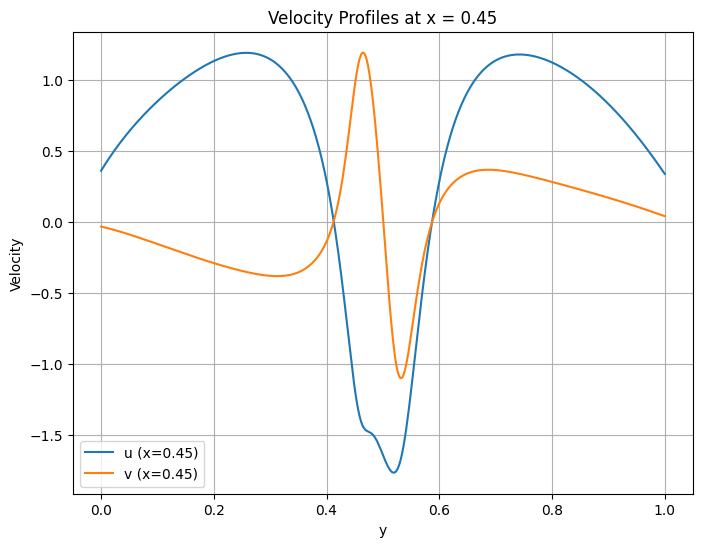

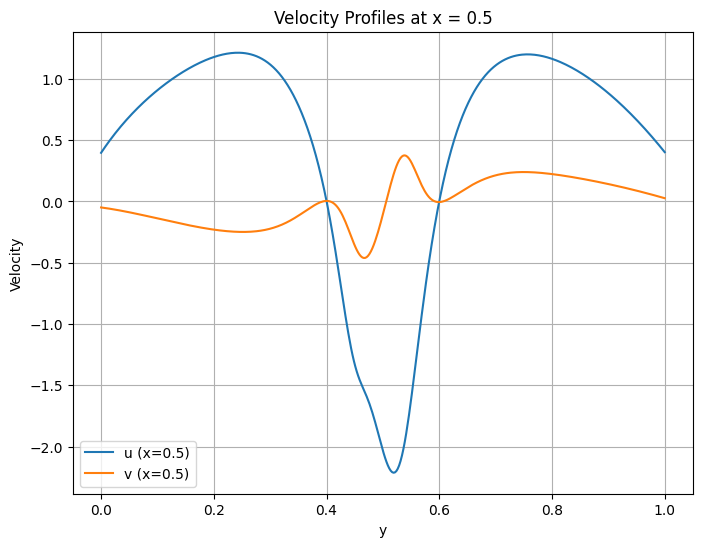

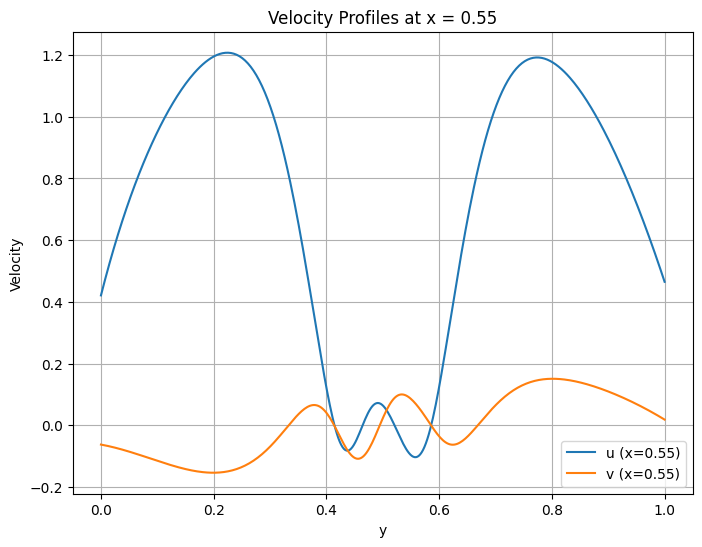

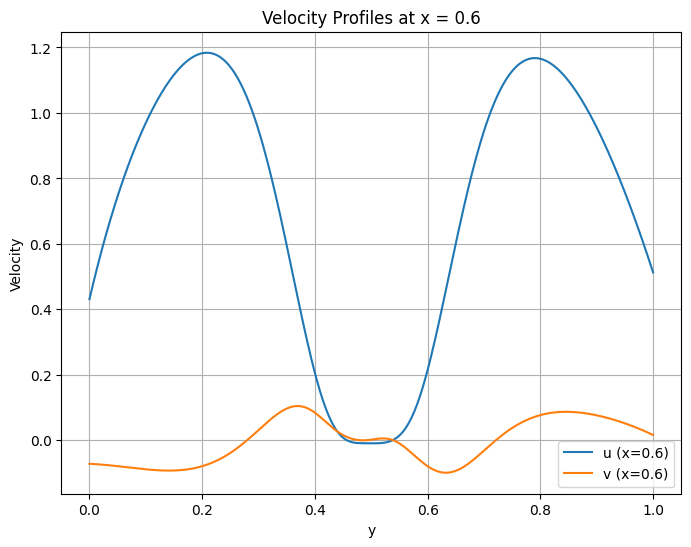

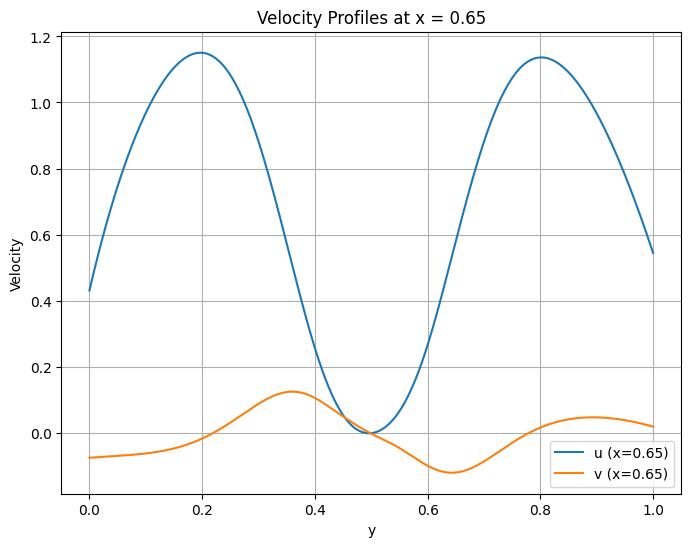

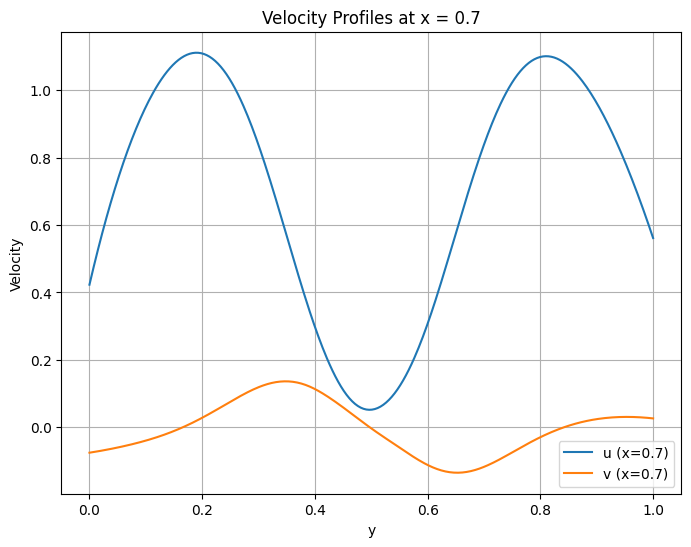

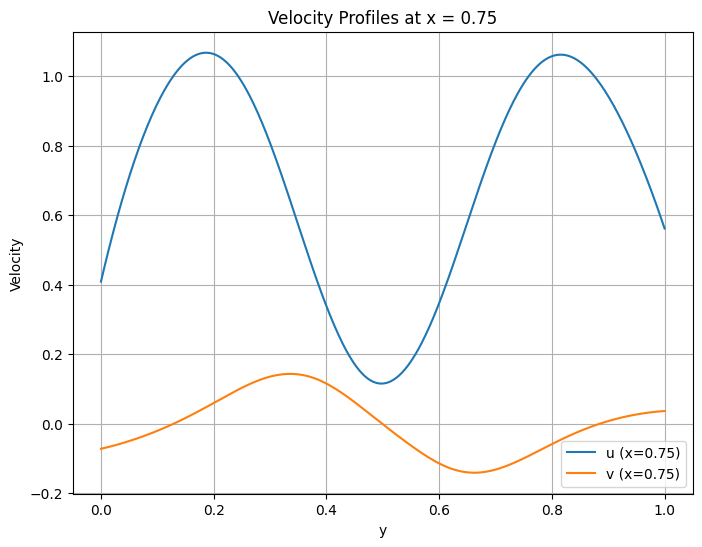

In [28]:
# Plot velocity profiles along specified cross-sections
import pandas as pd
cross_sections = [
    ('x', 0.30),
    ('x', 0.35),
    ('x', 0.40),
    ('x', 0.45),
    ('x', 0.50),
    ('x', 0.55),
    ('x', 0.60),
    ('x', 0.65),
    ('x', 0.70),
    ('x', 0.75),
]
plot_profiles(x, y, u, v, cross_sections, save_csv=False, prefix="u40_ofwl_roie5", location="../../data/pinn_profiles/")


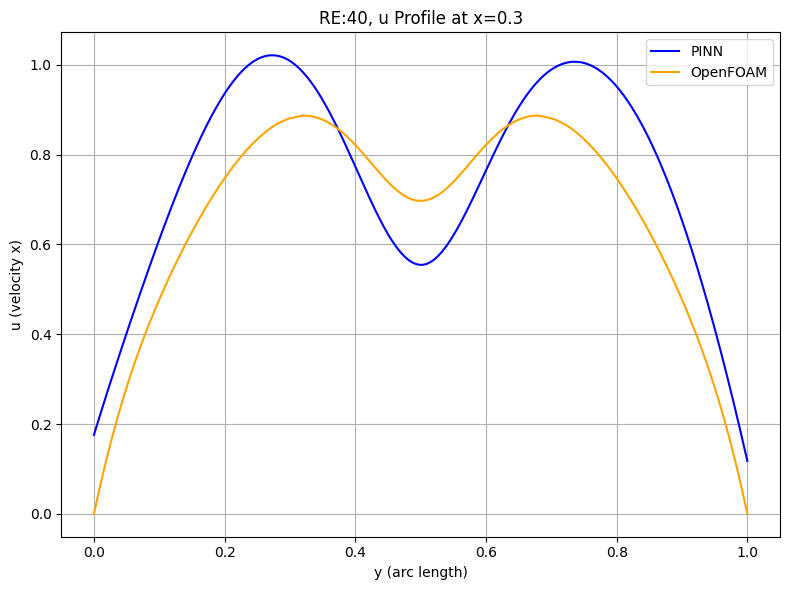

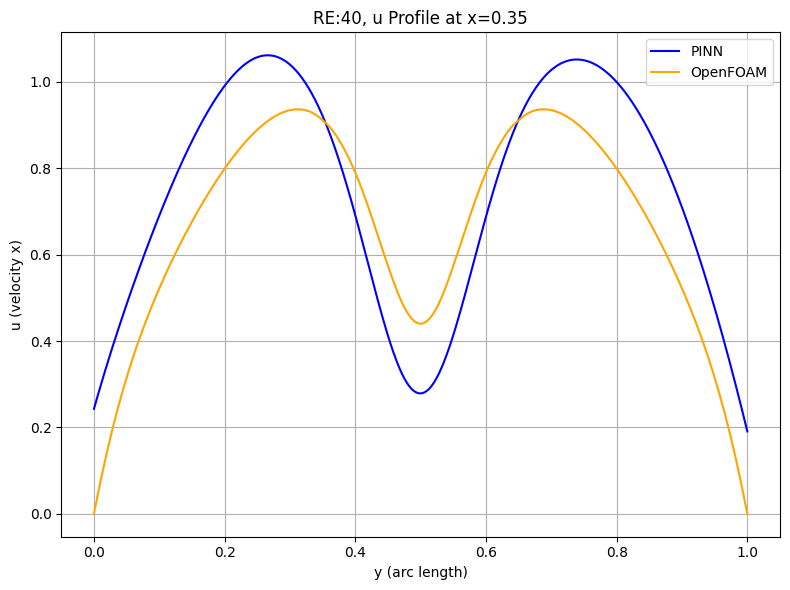

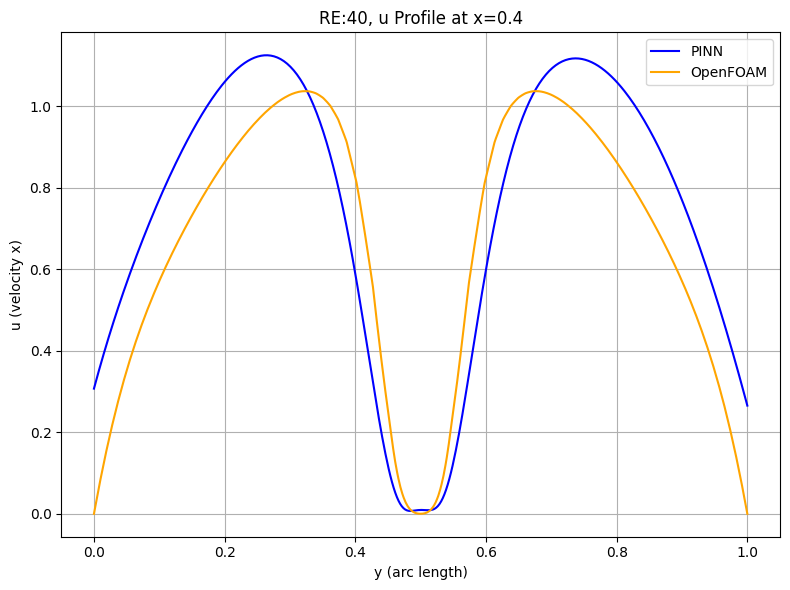

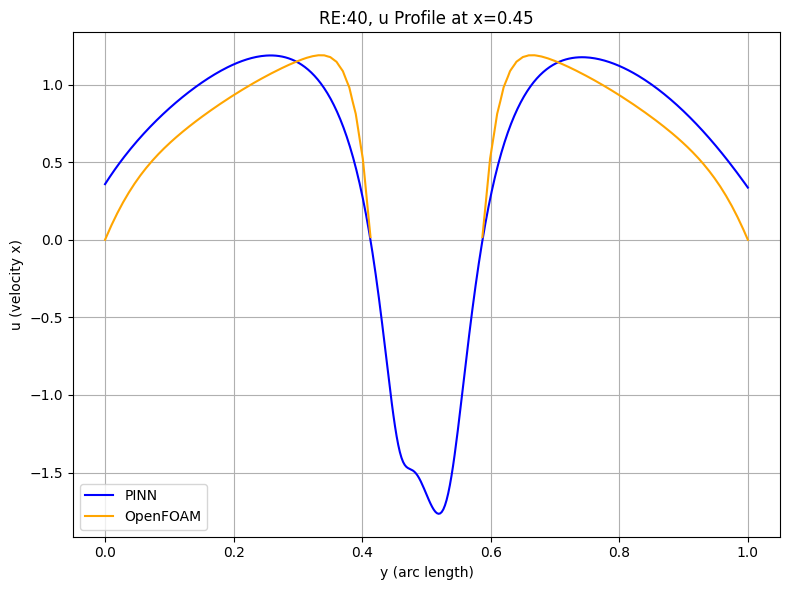

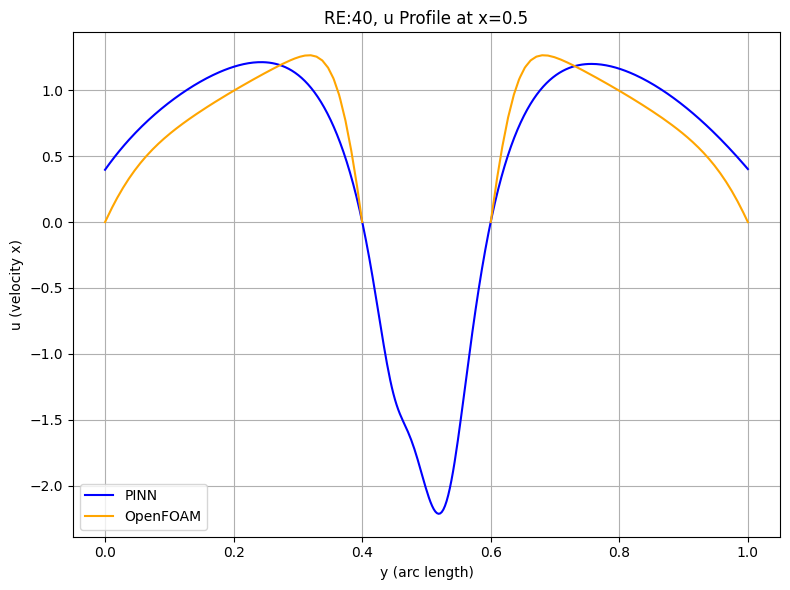

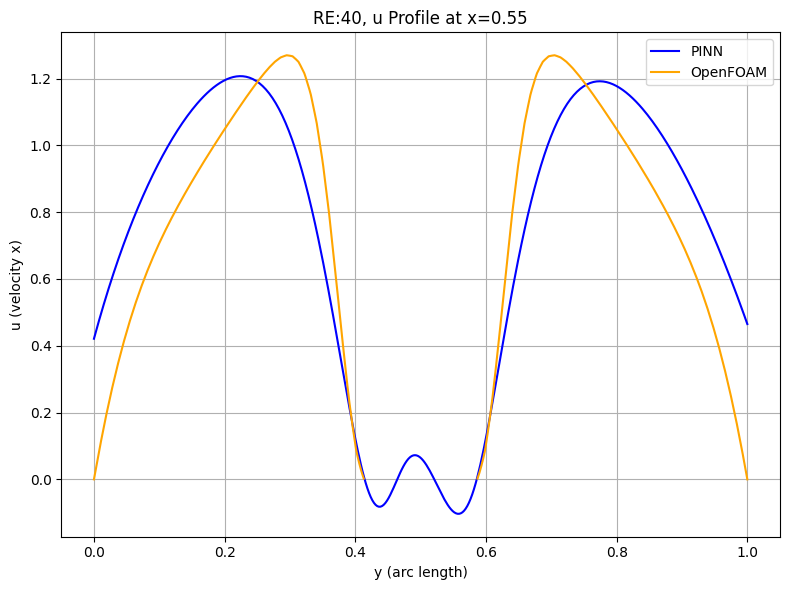

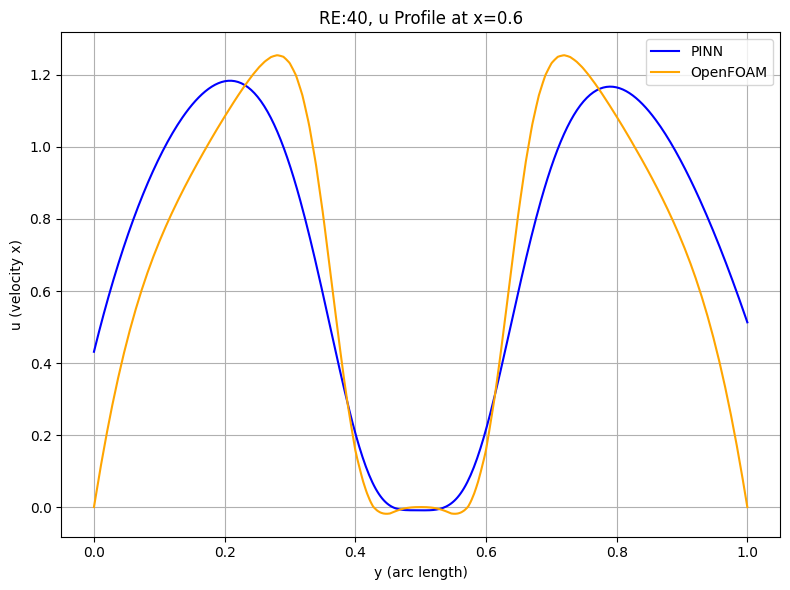

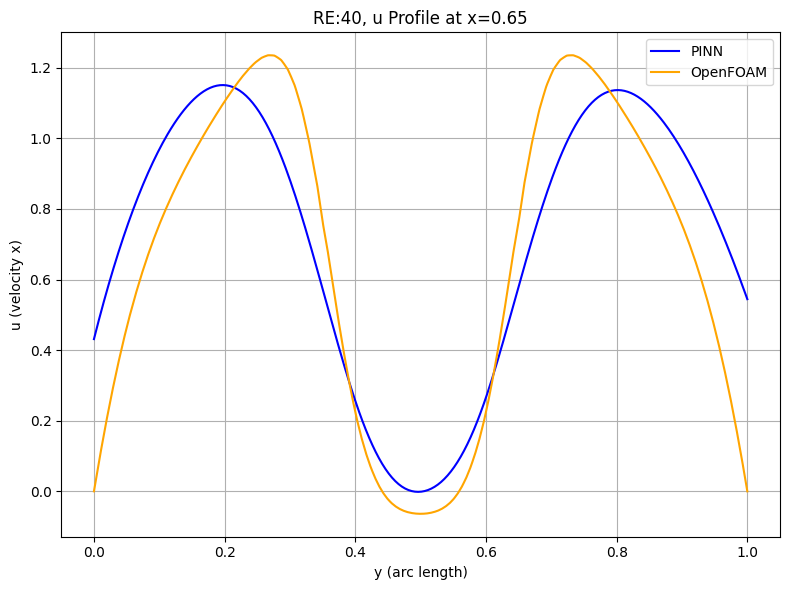

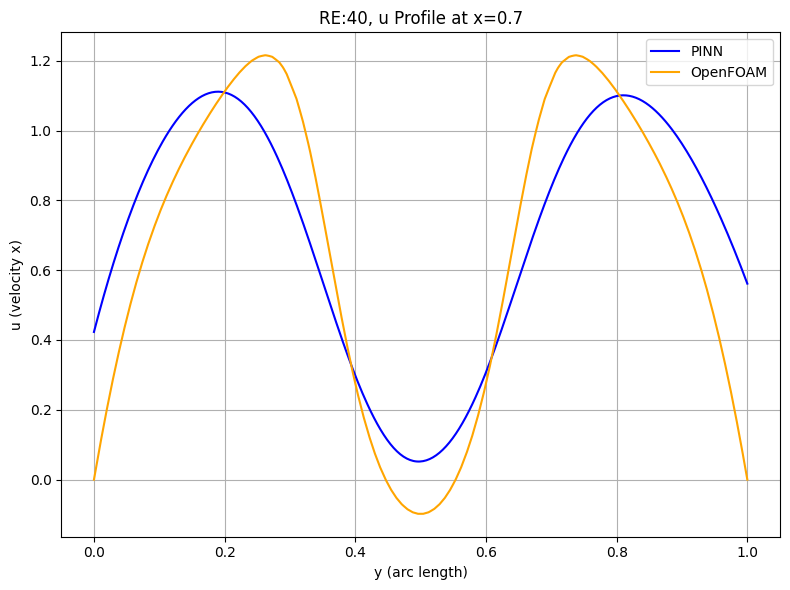

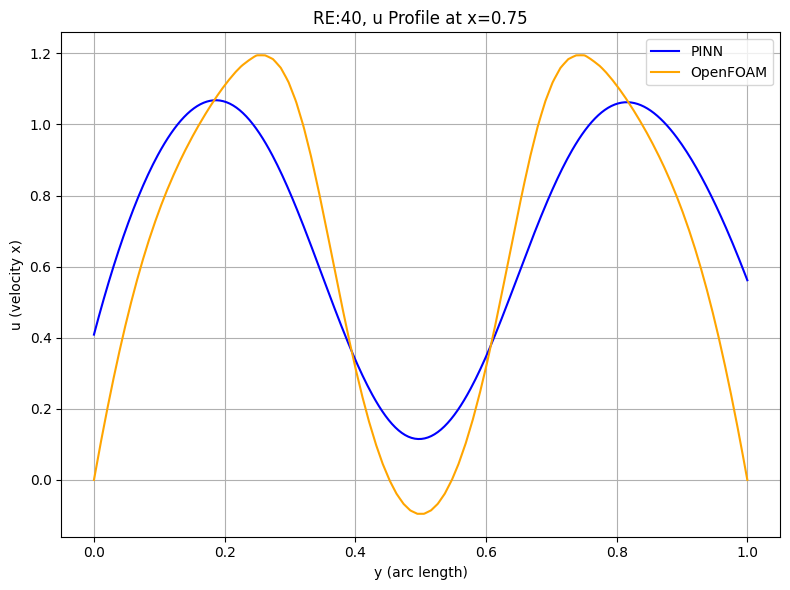

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="Velocity Profile Comparison"):
    """
    Plot and compare two velocity profiles along the same cross-section.
    Args:
        y_pinn: y-coordinates for PINN data.
        u_pinn: velocity values for PINN data.
        y_ref: y-coordinates for reference data (e.g., OpenFOAM).
        u_ref: velocity values for reference data.
        label_pinn: label for PINN data.
        label_ref: label for reference data.
        title: plot title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(y_pinn, u_pinn, label=label_pinn, color='blue')
    plt.plot(y_ref, u_ref, label=label_ref, color='orange')
    plt.xlabel('y (arc length)')
    plt.ylabel('u (velocity x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# List of cross-sections of interest
cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    # Load OpenFOAM reference data for this cross-section
    # Assumes file naming: data/Re10_cs/Re10_coarse_{x_target}.csv
    fname = f"../../data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        plot_profile_comparison(
            y_pinn, u_pinn, y_ref, u_ref,
            label_pinn="PINN",
            label_ref="OpenFOAM",
            title=f"RE:40, u Profile at x={x_target}"
        )
    except FileNotFoundError:
        print(f"Reference file not found: {fname}")

In [30]:
import numpy as np
from scipy.interpolate import interp1d

# y_pinn, u_pinn: PINN y and u values at x=0.75
# y_ref, u_ref: OpenFOAM y and u values at x=0.75

# Interpolate PINN profile onto OpenFOAM's y-coordinates
u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
u_pinn_on_ref = u_pinn_interp(y_ref)

# Compute errors
mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.1817
RMSE: 0.2122


In [35]:
lbfgs.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 gradient_layer (GradientLa  (((None, 1),                 7347      ['input_2[0][0]',             
 yer)                         (None, 1),                             'input_3[0][0]',             
                              (None, 1)),                            'input_5[0][0]',             
                              ((None, 1),                            'input_6[0][0]',       

In [ ]:
from tensorflow.keras.models import load_model
from layer import GradientLayer

loaded_pinn = load_model("pinn_dummysave.h5", custom_objects={'GradientLayer': GradientLayer})


/home/u019642/anaconda3/envs/pinnpy_3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: 
Layer GradientLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
# def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config